### Hypothesis 5: Locations with a higher concentration of companies have more applicants

In [1]:
# Import Required Libraries
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


In [2]:
# database connection details
db_type = 'postgresql'  
username = 'postgres'
password = 'abc123'
host = 'localhost'
port = '5432'  
database = 'DataEngineering'

# Create the connection string
connection_string = f'{db_type}://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string)


In [4]:
# Define the SQL query
from sqlalchemy import create_engine, text
query = """
select 
	l."Location",
	l."Location_id",
	c."Company_id",
	jp."Job_Posting_id"	

	from public."Job_Postings" jp
	join 
		public."Locations" l ON l."Location_id" = jp."Location_id"
	join 
		public."Companies" c on c."Company_id" = jp."Company_id"

	
	

"""
try:
    with engine.connect() as connection:
        result = connection.execute(text(query))
        data = result.fetchall()
        columns = result.keys()

    # Load the data into a Pandas DataFrame
    df = pd.DataFrame(data, columns=columns)
    print(df)

except Exception as e:
    print(f"Error executing query: {e}")

            Location  Location_id  Company_id  Job_Posting_id
0        Maharashtra           15           5               1
1              Delhi            7           5               2
2              Delhi            7           5               3
3          Telangana            3           5               4
4        Maharashtra           15           5               5
..               ...          ...         ...             ...
806   Madhya Pradesh           14           2             807
807           Odisha            5           2             808
808        Rajasthan           11           1             809
809        Telangana            3           1             810
810        Rajasthan           11           1             811

[811 rows x 4 columns]


In [5]:
print(df.head())
print(df.info())
print(df.describe(include='all'))

       Location  Location_id  Company_id  Job_Posting_id
0   Maharashtra           15           5               1
1         Delhi            7           5               2
2         Delhi            7           5               3
3     Telangana            3           5               4
4   Maharashtra           15           5               5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Location        811 non-null    object
 1   Location_id     811 non-null    int64 
 2   Company_id      811 non-null    int64 
 3   Job_Posting_id  811 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 25.5+ KB
None
            Location  Location_id  Company_id  Job_Posting_id
count            811   811.000000  811.000000      811.000000
unique            16          NaN         NaN             NaN
top      Maharashtra          NaN         NaN   

## Feature Engineering

In [33]:
# Aggrigrating Number of Companies and Job postings based on the Location
df_loca = df.groupby('Location').agg({'Company_id': 'nunique', 'Job_Posting_id': 'count'}).reset_index()
df_loca

,Location,Company_id,Job_Posting_id
0,Andhra Pradesh,2,6
1,Delhi,5,48
2,Gujarat,2,14
3,Haryana,6,31
4,India,3,9
5,Karnataka,7,148
6,Kerala,4,10
7,Madhya Pradesh,4,7
8,Maharashtra,9,205
9,Odisha,3,9


In [40]:
df_loca.columns = ['Location','Num_Companies','Num_Jobs']
df_loca

,Location,Num_Companies,Num_Jobs
0,Andhra Pradesh,2,6
1,Delhi,5,48
2,Gujarat,2,14
3,Haryana,6,31
4,India,3,9
5,Karnataka,7,148
6,Kerala,4,10
7,Madhya Pradesh,4,7
8,Maharashtra,9,205
9,Odisha,3,9


### Data Visualization

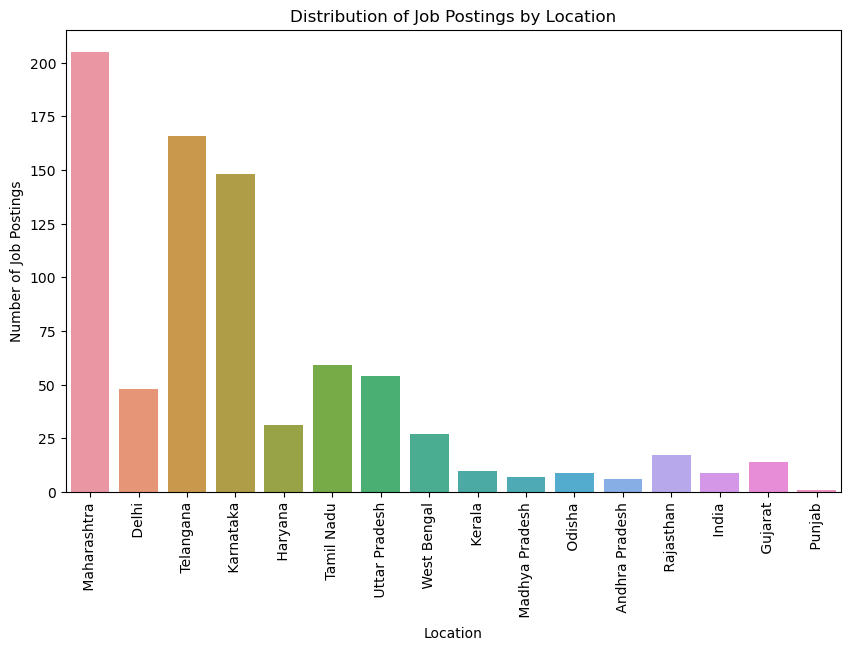

In [36]:
# Bar plot for the distribution of job postings across locations
plt.figure(figsize=(10, 6))
sns.countplot(x='Location', data=df)
plt.title('Distribution of Job Postings by Location')
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Number of Job Postings')
plt.show()

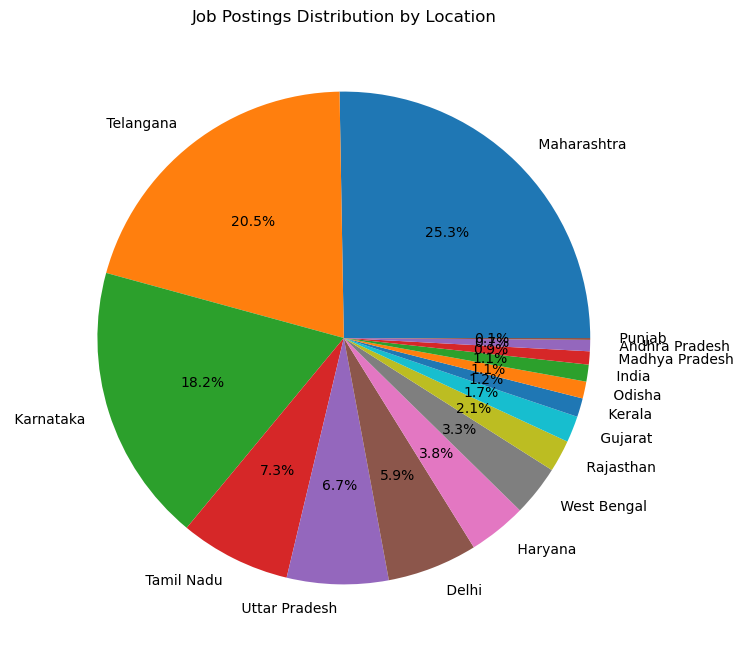

In [8]:
# Pie chart for the distribution of job postings across locations
plt.figure(figsize=(8, 8))
df['Location'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Job Postings Distribution by Location')
plt.ylabel('')
plt.show()

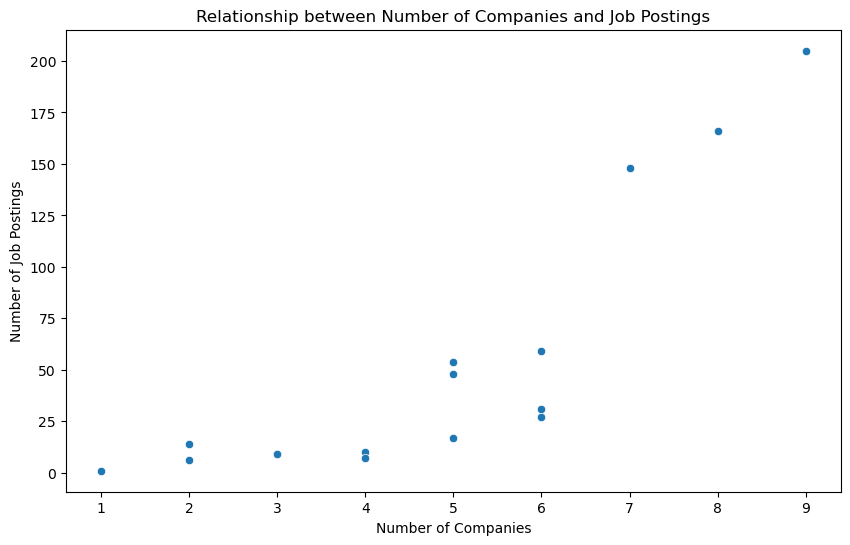

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Num_Companies', y='Num_Jobs', data=df_loca)
plt.title('Relationship between Number of Companies and Job Postings')
plt.xlabel('Number of Companies')
plt.ylabel('Number of Job Postings')
plt.show()


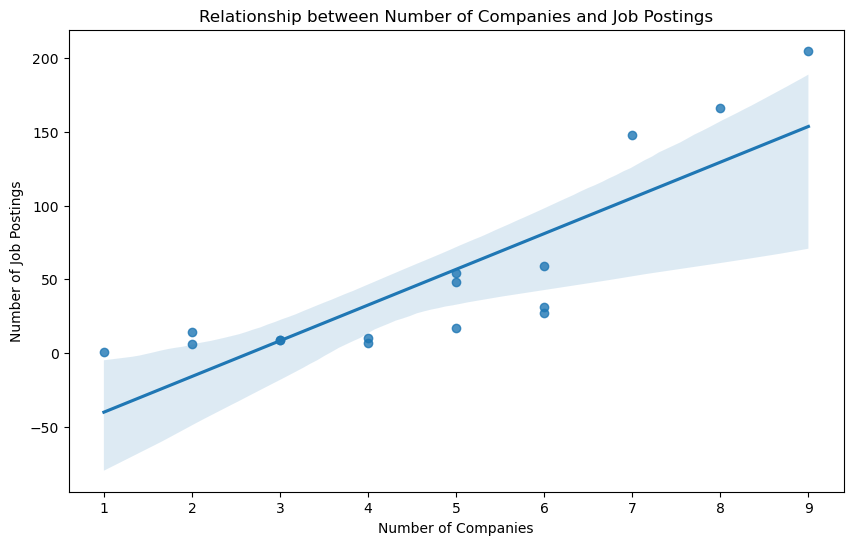

In [42]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Num_Companies', y='Num_Jobs', data=df_loca)
plt.title('Relationship between Number of Companies and Job Postings')
plt.xlabel('Number of Companies')
plt.ylabel('Number of Job Postings')
plt.show()


## We can obeserve a clear Corrilation between locations has higher constration companies with number of job postings

### Apply Machine Learning Models

In [43]:
df_loca

,Location,Num_Companies,Num_Jobs
0,Andhra Pradesh,2,6
1,Delhi,5,48
2,Gujarat,2,14
3,Haryana,6,31
4,India,3,9
5,Karnataka,7,148
6,Kerala,4,10
7,Madhya Pradesh,4,7
8,Maharashtra,9,205
9,Odisha,3,9


In [46]:
# Features and target
X = df_loca [['Num_Companies']]
y = df_loca['Num_Jobs']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

    Num_Companies
11              5
8               9
9               3
2               2
15              6
4               3
7               4
10              1
12              6
3               6
6               4
    Num_Companies
0               2
1               5
5               7
14              5
13              8
11     17
8     205
9       9
2      14
15     27
4       9
7       7
10      1
12     59
3      31
6      10
Name: Num_Jobs, dtype: int64
0       6
1      48
5     148
14     54
13    166
Name: Num_Jobs, dtype: int64


### k-Nearest Neighbors (k-NN)


In [55]:
knn = KNeighborsClassifier(n_neighbors=3)  # You can tune the n_neighbors parameter
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluation function
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, R2: {r2:.2f}")
    
print("\nK-Nearest Neighbors:")
evaluate_model(y_test, y_pred_knn, "K-Nearest Neighbors Regressor")
#print("Accuracy:", accuracy_score(y_test, y_pred_knn))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
#print("Classification Report:\n", classification_report(y_test, y_pred_knn))


K-Nearest Neighbors:
K-Nearest Neighbors Regressor - MSE: 7572.20, R2: -0.98


### Random Forest

In [56]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest:")
evaluate_model(y_test, y_pred_knn, "Random Forest Regressor")


Random Forest:
Random Forest Regressor - MSE: 7572.20, R2: -0.98


### XGBoost

In [58]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost:")
evaluate_model(y_test, y_pred_knn, "XGBoost Regressor")


XGBoost:
XGBoost Regressor - MSE: 7572.20, R2: -0.98


### Interpretation
#### In all three models accuracy score is 98% since it indicates that Locations with a higher concentration of companies have more applicants.


### According to above results, Hypothesis 5 is correct!